In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from dmba import classificationSummary
from sklearn import preprocessing
from sklearn.metrics import precision_recall_curve, roc_auc_score, roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
import matplotlib
from matplotlib import pyplot
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.neural_network import MLPClassifier 
from sklearn.ensemble import VotingClassifier
from scipy.stats import loguniform

no display found. Using non-interactive Agg backend


In [2]:
matplotlib.use('TkAgg')
%matplotlib inline

In [3]:
import matplotlib.pyplot as plt
import mplcyberpunk

# Load in data and preprocess

In [4]:
tracks = pd.read_csv('tracks_v2.csv')

In [5]:
#create a target variable "charted"

mask = tracks['chart_status'] > 0
tracks['charted'] = np.where(mask, 1, 0)

In [6]:
tracks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14740 entries, 0 to 14739
Data columns (total 70 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             14740 non-null  object 
 1   name                           14739 non-null  object 
 2   album                          14739 non-null  object 
 3   album_id                       14740 non-null  object 
 4   artists                        14722 non-null  object 
 5   artist_ids                     14740 non-null  object 
 6   track_number                   14740 non-null  int64  
 7   disc_number                    14740 non-null  int64  
 8   explicit                       14740 non-null  bool   
 9   duration_ms                    14740 non-null  int64  
 10  year                           14740 non-null  int64  
 11  release_date                   14740 non-null  object 
 12  popularity                     14740 non-null 

In [7]:
df2 = tracks.iloc[:, lambda df: [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 69]].copy()
df2.dropna(inplace=True)

In [8]:
df2.head()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,charted
0,0.811,0.692,4.0,-2.836,0.0,0.1050,0.00937,0.000000,0.0598,0.8170,125.009,4.0,0
1,0.873,0.505,9.0,-8.554,1.0,0.0646,0.69300,0.001700,0.1080,0.5820,100.037,4.0,0
2,0.740,0.583,9.0,-7.095,0.0,0.0312,0.11600,0.000774,0.2380,0.3460,101.011,4.0,0
3,0.806,0.558,9.0,-6.460,1.0,0.0683,0.48200,0.000000,0.0618,0.6780,95.016,4.0,0
4,0.437,0.360,7.0,-10.202,1.0,0.0505,0.57500,0.000000,0.0902,0.0935,173.916,3.0,0


# Create functions to evaluate model performance

In [9]:
def model_performance_plots(trainX, trainy, testX, testy, model):
    m = model
    m.fit(trainX, trainy)
    lr_probs = m.predict_proba(testX)
    
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # predict class values
    yhat = model.predict(testX)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    
    # summarize scores
    print(f'Model: {model}')
    print(f'f1 score: {lr_f1}')
    print(f'auc: {lr_auc}')
    print(f'Precision Score: {precision_score(testy, yhat)}')
    print(f'Accuracy Score: {accuracy_score(testy, yhat)}')
    
    #
    pyplot.style.use("cyberpunk")

    mplcyberpunk.add_glow_effects()
    
    #
    ns_probs = [0 for _ in range(len(testy))]    
    # calculate scores
    ns_auc = roc_auc_score(testy, ns_probs)
    lr_auc = roc_auc_score(testy, lr_probs)
    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print('Model: ROC AUC=%.3f' % (lr_auc))
    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(testy, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(testy, lr_probs)
    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
    # axis labels
    pyplot.xlabel('False Positive Rate LNM')
    pyplot.ylabel('True Positive Rate LNM')
    # show the legend
    pyplot.legend()
    # show the plot
    pyplot.show()
    #
    #
    
    # plot the precision-recall curves
    no_skill = len(testy[testy==1]) / len(testy)
    pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
    pyplot.plot(lr_recall, lr_precision, marker='.')
    
    # axis labels
    pyplot.xlabel('Recall')
    pyplot.ylabel('Precision')

    # show the legend
    pyplot.legend()
    pyplot.show()
    
    #create confusion matrix
    cm = confusion_matrix(testy, yhat, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)
    disp.plot()

In [10]:
def model_performance(trainX, trainy, testX, testy, model):
    m = model
    m.fit(trainX, trainy)
    lr_probs = m.predict_proba(testX)
    
    # keep probabilities for the positive outcome only
    lr_probs = lr_probs[:, 1]

    # predict class values
    yhat = model.predict(testX)
    lr_precision, lr_recall, _ = precision_recall_curve(testy, lr_probs)
    lr_f1, lr_auc = f1_score(testy, yhat), auc(lr_recall, lr_precision)
    
    # summarize scores
    print(f'Model: {model}')
    print(f'f1 score: {lr_f1}')
    print(f'auc: {lr_auc}')
    print(f'Precision Score: {precision_score(testy, yhat)}')
    print(f'Accuracy Score: {accuracy_score(testy, yhat)}')
    print()
    

In [11]:
def confm(valid_x, valid_y, model, threshold):
    
    probs = model.predict_proba(valid_X)[:, 1]
    probabilities_pred = np.where(probs > threshold, 1, 0)
    print(f'f1 score: {f1_score(valid_y, probabilities_pred)}')
    print(f'Precision Score: {precision_score(valid_y, probabilities_pred)}')
    print(f'Accuracy Score: {accuracy_score(valid_y, probabilities_pred)}')
    print()

    cm = confusion_matrix(valid_y, probabilities_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=model.classes_)


    disp.plot()

# Prepare date for analysis

## Train/Test Split

In [12]:
#define x and y and create train test split

X = df2.drop('charted', axis=1)
y = df2['charted']

train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.3, random_state=23)

## Scaled data for NN and SVM

In [13]:
#create scaled data

scaler = StandardScaler()
X_scaled=X.copy()
X_scaled=pd.DataFrame(scaler.fit_transform(X_scaled), columns=X_scaled.columns)

train_Xs, valid_Xs, train_ys, valid_ys = train_test_split(X_scaled, y, test_size=0.3, random_state=23)

# Define potential models - Logisitic Regression, Random Forest, SVM, Decision Trees, Neural Net

In [14]:
#potential models

logit_clf = LogisticRegression(penalty="l1", C=1e42, solver='liblinear')
rnd_clf = RandomForestClassifier(max_depth = 30, max_leaf_nodes= 50, min_impurity_decrease= 0.001, min_samples_split= 5, random_state=23)
svm_clf = SVC(gamma="auto", probability=True, random_state=23)
dtree_clf = DecisionTreeClassifier(random_state=23)
NN_clf = MLPClassifier(hidden_layer_sizes=(10), activation='logistic', solver='lbfgs', 
                    random_state=23, max_iter=5000)

models_unscaled = [logit_clf, rnd_clf, dtree_clf]
models_scaled = [svm_clf, NN_clf]

# Fit and look at performance metrics of models

In [15]:
for i in models_unscaled:
    model_performance(train_X, train_y, valid_X, valid_y, i)

Model: LogisticRegression(C=1e+42, penalty='l1', solver='liblinear')
f1 score: 0.0
auc: 0.28186969293677344
Precision Score: 0.0
Accuracy Score: 0.7955676164631389



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: RandomForestClassifier(max_depth=30, max_leaf_nodes=50,
                       min_impurity_decrease=0.001, min_samples_split=5,
                       random_state=23)
f1 score: 0.0
auc: 0.28903251577348676
Precision Score: 0.0
Accuracy Score: 0.7955676164631389



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: DecisionTreeClassifier(random_state=23)
f1 score: 0.23746701846965698
auc: 0.31367734011707427
Precision Score: 0.22704339051463168
Accuracy Score: 0.6732247851650837



In [16]:
for i in models_scaled:
    model_performance(train_Xs, train_ys, valid_Xs, valid_ys, i)

Model: SVC(gamma='auto', probability=True, random_state=23)
f1 score: 0.0
auc: 0.22642612452554572
Precision Score: 0.0
Accuracy Score: 0.7955676164631389



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Model: MLPClassifier(activation='logistic', hidden_layer_sizes=10, max_iter=5000,
              random_state=23, solver='lbfgs')
f1 score: 0.0364741641337386
auc: 0.26209649475866487
Precision Score: 0.21686746987951808
Accuracy Score: 0.7849389416553596



## Plots for Neural Net

Model: MLPClassifier(activation='logistic', hidden_layer_sizes=10, max_iter=5000,
              random_state=23, solver='lbfgs')
f1 score: 0.0364741641337386
auc: 0.26209649475866487
Precision Score: 0.21686746987951808
Accuracy Score: 0.7849389416553596
No Skill: ROC AUC=0.500
Model: ROC AUC=0.612


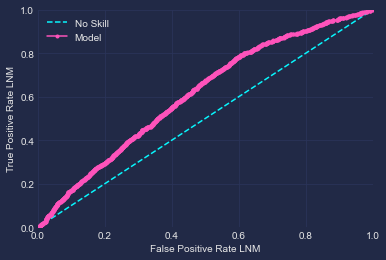

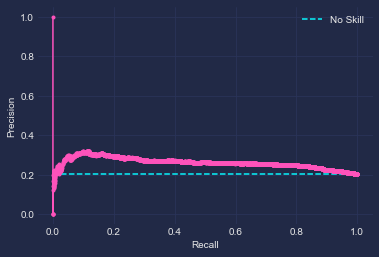

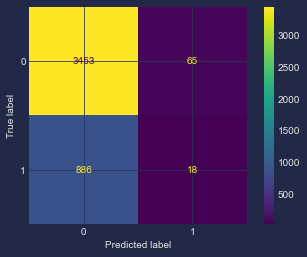

In [17]:
model_performance_plots(train_Xs, train_ys, valid_Xs, valid_ys, NN_clf)

## Plots for Decision Tree

Model: DecisionTreeClassifier(random_state=23)
f1 score: 0.23746701846965698
auc: 0.31367734011707427
Precision Score: 0.22704339051463168
Accuracy Score: 0.6732247851650837
No Skill: ROC AUC=0.500
Model: ROC AUC=0.514


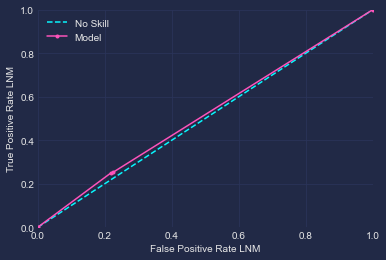

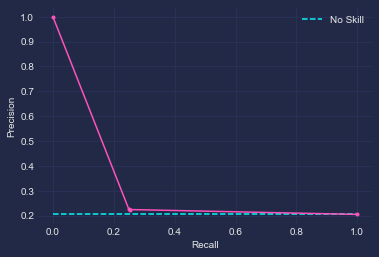

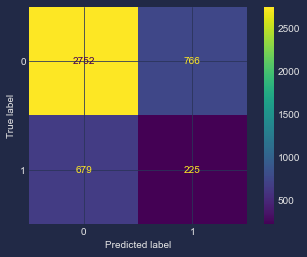

In [18]:
model_performance_plots(train_X, train_y, valid_X, valid_y, dtree_clf)

## Plots for Random Forest

Model: RandomForestClassifier(max_depth=30, max_leaf_nodes=50,
                       min_impurity_decrease=0.001, min_samples_split=5,
                       random_state=23)
f1 score: 0.0
auc: 0.28903251577348676
Precision Score: 0.0
Accuracy Score: 0.7955676164631389
No Skill: ROC AUC=0.500
Model: ROC AUC=0.631


/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


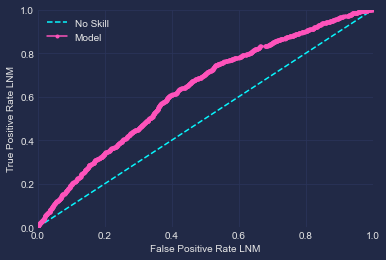

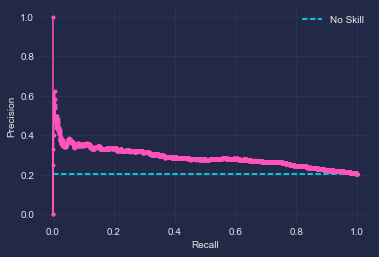

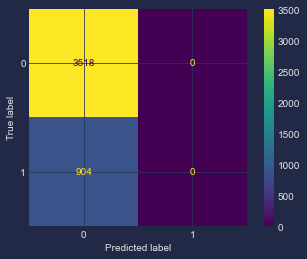

In [19]:
model_performance_plots(train_X, train_y, valid_X, valid_y, rnd_clf)

# Try oversampling the minority class

In [20]:
import imblearn
from imblearn.over_sampling import RandomOverSampler

In [21]:
oversample = RandomOverSampler(sampling_strategy='minority')
over_train_X, over_train_y = oversample.fit_resample(train_X, train_y)
over_train_Xs, over_train_ys = oversample.fit_resample(train_Xs, train_ys)

In [22]:
for i in models_unscaled:
    model_performance(over_train_X, over_train_y, valid_X, valid_y, i)

Model: LogisticRegression(C=1e+42, penalty='l1', solver='liblinear')
f1 score: 0.3764270286948473
auc: 0.2802445707431366
Precision Score: 0.2610183996576808
Accuracy Score: 0.5429669832654908

Model: RandomForestClassifier(max_depth=30, max_leaf_nodes=50,
                       min_impurity_decrease=0.001, min_samples_split=5,
                       random_state=23)
f1 score: 0.38734353268428373
auc: 0.29499980581797747
Precision Score: 0.28245436105476673
Accuracy Score: 0.6015377657168702

Model: DecisionTreeClassifier(random_state=23)
f1 score: 0.25436681222707425
auc: 0.3297280971976472
Precision Score: 0.2510775862068966
Accuracy Score: 0.6910900045228403



In [23]:
for i in models_scaled:
    model_performance(over_train_Xs, over_train_ys, valid_Xs, valid_ys, i)

Model: SVC(gamma='auto', probability=True, random_state=23)
f1 score: 0.3957361758827448
auc: 0.2946383387590995
Precision Score: 0.2831267874165872
Accuracy Score: 0.5897783808231569

Model: MLPClassifier(activation='logistic', hidden_layer_sizes=10, max_iter=5000,
              random_state=23, solver='lbfgs')
f1 score: 0.36416819012797075
auc: 0.26876651481016955
Precision Score: 0.2719825232113599
Accuracy Score: 0.6067390321121664



## Performance plot for the neural net model w/ oversampling

Model: MLPClassifier(activation='logistic', hidden_layer_sizes=10, max_iter=5000,
              random_state=23, solver='lbfgs')
f1 score: 0.36416819012797075
auc: 0.26876651481016955
Precision Score: 0.2719825232113599
Accuracy Score: 0.6067390321121664
No Skill: ROC AUC=0.500
Model: ROC AUC=0.620


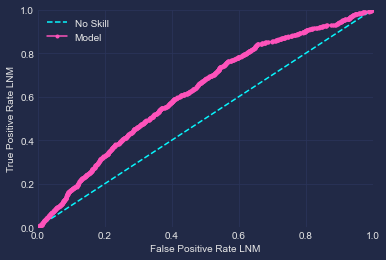

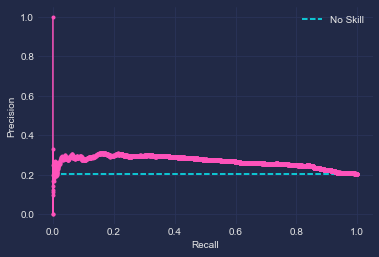

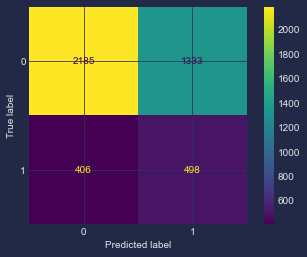

In [24]:
model_performance_plots(over_train_Xs, over_train_ys, valid_Xs, valid_ys, NN_clf)

## Performance plot for logistic regression model w/ oversampling


Model: RandomForestClassifier(max_depth=30, max_leaf_nodes=50,
                       min_impurity_decrease=0.001, min_samples_split=5,
                       random_state=23)
f1 score: 0.38734353268428373
auc: 0.29499980581797747
Precision Score: 0.28245436105476673
Accuracy Score: 0.6015377657168702
No Skill: ROC AUC=0.500
Model: ROC AUC=0.642


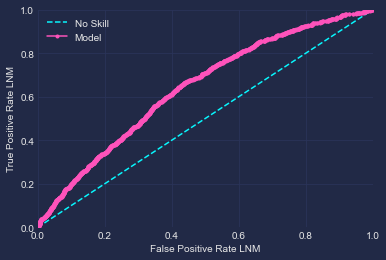

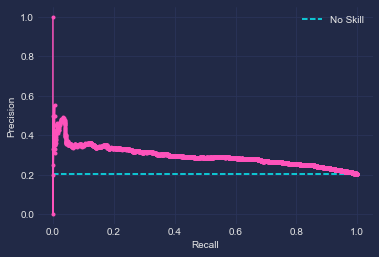

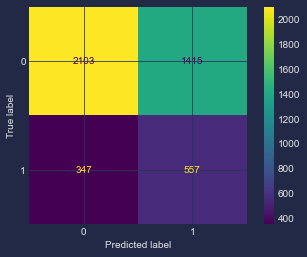

In [25]:
model_performance_plots(over_train_X, over_train_y, valid_X, valid_y, rnd_clf)

## Performance plot for random forest model w/ oversampling

Model: RandomForestClassifier(max_depth=30, max_leaf_nodes=50,
                       min_impurity_decrease=0.001, min_samples_split=5,
                       random_state=23)
f1 score: 0.38734353268428373
auc: 0.29499980581797747
Precision Score: 0.28245436105476673
Accuracy Score: 0.6015377657168702
No Skill: ROC AUC=0.500
Model: ROC AUC=0.642


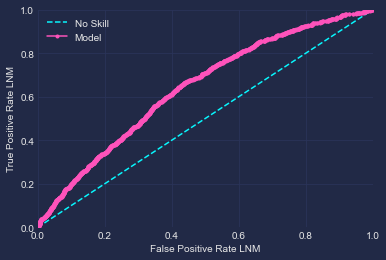

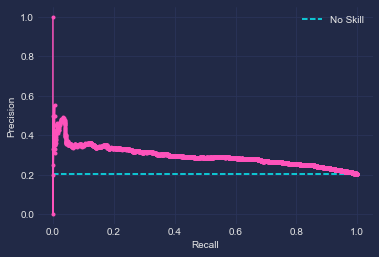

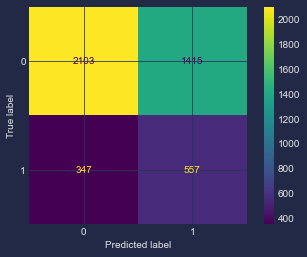

In [26]:
model_performance_plots(over_train_X, over_train_y, valid_X, valid_y, rnd_clf)

Oversampling seemed to improve the results accross the board, so moving forward I will use the oversampled training set

# Trying ensemble methods

## Voting set to 'hard'

In [27]:
voting_clf = VotingClassifier(
    estimators=[('lr', logit_clf), ('rf', rnd_clf), ('dt', dtree_clf)],
    voting='hard')

In [28]:
voting_clf.fit(over_train_X, over_train_y)

VotingClassifier(estimators=[('lr',
                              LogisticRegression(C=1e+42, penalty='l1',
                                                 solver='liblinear')),
                             ('rf',
                              RandomForestClassifier(max_depth=30,
                                                     max_leaf_nodes=50,
                                                     min_impurity_decrease=0.001,
                                                     min_samples_split=5,
                                                     random_state=23)),
                             ('dt', DecisionTreeClassifier(random_state=23))])

In [29]:
for clf in (logit_clf, rnd_clf, dtree_clf, voting_clf):
    clf.fit(over_train_X, over_train_y)
    pred_y = clf.predict(valid_X)
    print(clf.__class__.__name__, accuracy_score(valid_y, pred_y))
    print(clf.__class__.__name__, precision_score(valid_y, pred_y))
    print(clf.__class__.__name__, f1_score(valid_y, pred_y))

LogisticRegression 0.5429669832654908
LogisticRegression 0.2610183996576808
LogisticRegression 0.3764270286948473
RandomForestClassifier 0.6015377657168702
RandomForestClassifier 0.28245436105476673
RandomForestClassifier 0.38734353268428373
DecisionTreeClassifier 0.6910900045228403
DecisionTreeClassifier 0.2510775862068966
DecisionTreeClassifier 0.25436681222707425
VotingClassifier 0.6126187245590231
VotingClassifier 0.2881089575694081
VotingClassifier 0.39104159260575905


## Voting set to 'soft'

In [30]:
voting_clf = VotingClassifier(
    estimators=[('lr', logit_clf), ('rf', rnd_clf), ('dt', dtree_clf)],
    voting='soft')

In [31]:
for clf in (logit_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(over_train_X, over_train_y)
    pred_y = clf.predict(valid_X)
    print(clf.__class__.__name__, accuracy_score(valid_y, pred_y))
    print(clf.__class__.__name__, precision_score(valid_y, pred_y))
    print(clf.__class__.__name__, f1_score(valid_y, pred_y))

LogisticRegression 0.5429669832654908
LogisticRegression 0.2610183996576808
LogisticRegression 0.3764270286948473
RandomForestClassifier 0.6015377657168702
RandomForestClassifier 0.28245436105476673
RandomForestClassifier 0.38734353268428373
SVC 0.5680687471732248
SVC 0.24595959595959596
SVC 0.3377253814147018
VotingClassifier 0.6917684305744007
VotingClassifier 0.2529601722282024
VotingClassifier 0.25641025641025644


The ensemble methods didn't seem to make much difference, and they're a lot slower. Will probably stick to tuning some of the simpler models

# Threshold Testing

### function to calculate threshold to maximize precision

In [32]:
from numpy import arange
from numpy import argmax

def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

def thresholds (testX, testy, model):
    yhat = model.predict_proba(testX)
    # keep probabilities for the positive outcome only
    probs = yhat[:, 1]
    # define thresholds
    thresholds = arange(0, 1, 0.01)
    # evaluate each threshold
    scores = [precision_score(testy, to_labels(probs, t)) for t in thresholds]
    # get best threshold
    ix = argmax(scores)
    print('Threshold=%.3f, Precision-Score=%.5f' % (thresholds[ix], scores[ix]))

## Logistic Regression - Threshold Testing

In [33]:
import warnings
warnings.filterwarnings("ignore")

In [34]:
logit_clf.fit(over_train_X, over_train_y)

LogisticRegression(C=1e+42, penalty='l1', solver='liblinear')

In [35]:
x = np.arange(.01,1,.01)
probs = logit_clf.predict_proba(valid_X)[:, 1]
for i in x:
    probabilities_pred = np.where(probs > i, 1, 0)
    p = precision_score(valid_y, probabilities_pred)
    if p > 0.35:
        print(i, p)

0.7000000000000001 0.37037037037037035
0.7100000000000001 0.4444444444444444
0.72 0.4166666666666667
0.73 0.4


In [36]:
thresholds(valid_X, valid_y, logit_clf)

Threshold=0.710, Precision-Score=0.44444


f1 score: 0.3611767232123685
Precision Score: 0.22408739674926725
Accuracy Score: 0.3272274988692899



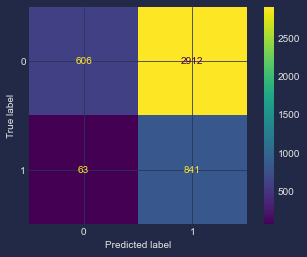

In [37]:
confm(valid_X, valid_y, logit_clf, 0.34)

## Random Forest - Threshold Testing

In [38]:
rnd_clf.fit(over_train_X, over_train_y)

RandomForestClassifier(max_depth=30, max_leaf_nodes=50,
                       min_impurity_decrease=0.001, min_samples_split=5,
                       random_state=23)

In [39]:
x = np.arange(.01,1,.01)
probs = rnd_clf.predict_proba(valid_X)[:, 1]
for i in x:
    probabilities_pred = np.where(probs > i, 1, 0)
    p = precision_score(valid_y, probabilities_pred)
    if p > 0.35:
        print(i, p)

0.61 0.3548387096774194
0.62 0.35333333333333333
0.63 0.4788732394366197
0.64 0.5


In [40]:
thresholds(valid_X, valid_y, rnd_clf)

Threshold=0.640, Precision-Score=0.50000


f1 score: 0.10056925996204934
Precision Score: 0.35333333333333333
Accuracy Score: 0.7856173677069199



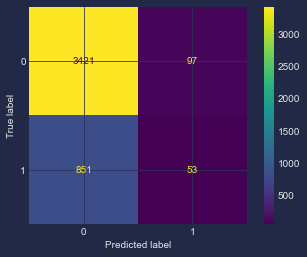

In [41]:
confm(valid_X, valid_y, rnd_clf, 0.62)

## Neural Net - Threshold Testing

In [42]:
NN_clf.fit(over_train_X, over_train_y)

MLPClassifier(activation='logistic', hidden_layer_sizes=10, max_iter=5000,
              random_state=23, solver='lbfgs')

In [43]:
x = np.arange(.01,1,.01)
probs = rnd_clf.predict_proba(valid_X)[:, 1]
for i in x:
    probabilities_pred = np.where(probs > i, 1, 0)
    p = precision_score(valid_y, probabilities_pred)
    if p > 0.35:
        print(i, p)

0.61 0.3548387096774194
0.62 0.35333333333333333
0.63 0.4788732394366197
0.64 0.5


In [44]:
thresholds(valid_X, valid_y, rnd_clf)

Threshold=0.640, Precision-Score=0.50000


f1 score: 0.010940919037199124
Precision Score: 0.5
Accuracy Score: 0.7955676164631389



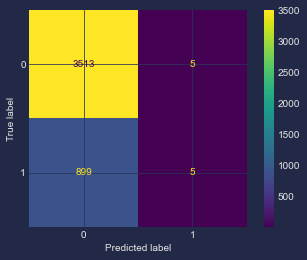

In [45]:
confm(valid_X, valid_y, rnd_clf, 0.64)

# Hyper Parameter Tuning - Logistic Regression

In [46]:
model = LogisticRegression()
# define evaluation
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = loguniform(1e-5, 100)
# define search
search = RandomizedSearchCV(model, space, n_iter=500, scoring='precision', n_jobs=-1, cv=2, random_state=1)
# execute search
result = search.fit(over_train_X, over_train_y)
# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.5889096460805159
Best Hyperparameters: {'C': 26.779972328542662, 'penalty': 'l1', 'solver': 'liblinear'}


# Hyper Parameter Tuning - MLPClassifier

In [47]:
model = MLPClassifier()

# define search space
space = dict()
space['hidden_layer_sizes'] = [(2,5),(5,10),(10,20)]
space['activation'] = ['logistic', 'tanh', 'relu']
space['solver'] = ['lbfgs', 'sgd', 'adam']
space['learning_rate'] = ['constant', 'adaptive']

# define search
search = RandomizedSearchCV(model, space, scoring='precision', n_jobs=-1, cv=2, random_state=1)

# execute search
result = search.fit(over_train_Xs, over_train_ys)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.6389811726799868
Best Hyperparameters: {'solver': 'lbfgs', 'learning_rate': 'constant', 'hidden_layer_sizes': (10, 20), 'activation': 'tanh'}


In [48]:
NN_optimized = MLPClassifier(activation = 'tanh',
                             hidden_layer_sizes= (10, 20),
                             learning_rate='constant',
                             solver= 'lbfgs',
                            max_iter = 500)
NN_optimized

MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 20), max_iter=500,
              solver='lbfgs')

Model: MLPClassifier(activation='tanh', hidden_layer_sizes=(10, 20), max_iter=500,
              solver='lbfgs')
f1 score: 0.3476621417797889
auc: 0.26041999986431213
Precision Score: 0.2637299771167048
Accuracy Score: 0.6087743102668476
No Skill: ROC AUC=0.500
Model: ROC AUC=0.595


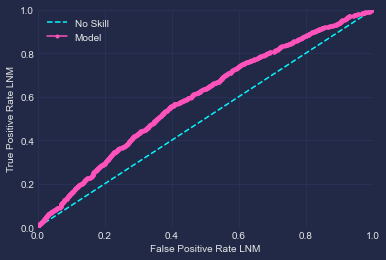

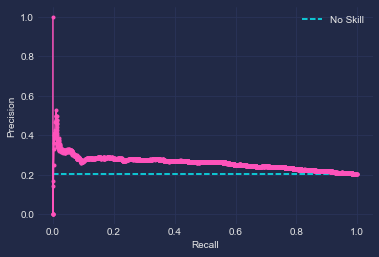

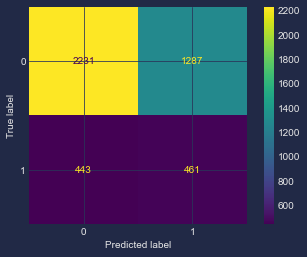

In [49]:
model_performance_plots(over_train_Xs, over_train_ys, valid_Xs, valid_ys, NN_optimized)

# Hyper Parameter Tuning - Random Forest

In [50]:
model = RandomForestClassifier()

# define search space

space = {'min_samples_split': [5, 20, 35, 50], 
    'max_leaf_nodes': [50, 75, 100, 125],
    'min_impurity_decrease': [0, .0001, .001],
    'max_depth': [20, 40, 60, 80, 100]
        }

# define search
search = RandomizedSearchCV(model, space, scoring='precision', n_jobs=-1, cv=5, random_state=1)

# execute search
result = search.fit(over_train_X, over_train_y)

# summarize result
print('Best Score: %s' % result.best_score_)
print('Best Hyperparameters: %s' % result.best_params_)

Best Score: 0.7038637705172096
Best Hyperparameters: {'min_samples_split': 5, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': 125, 'max_depth': 40}


In [51]:
rf_optimized = RandomForestClassifier(min_samples_split= 5, 
                                       min_impurity_decrease= 0.0001,
                                       max_leaf_nodes= 125, 
                                       max_depth= 40)

Model: RandomForestClassifier(max_depth=40, max_leaf_nodes=125,
                       min_impurity_decrease=0.0001, min_samples_split=5)
f1 score: 0.3914209115281502
auc: 0.29914875140027797
Precision Score: 0.29935559461042766
Accuracy Score: 0.6406603346901855
No Skill: ROC AUC=0.500
Model: ROC AUC=0.654


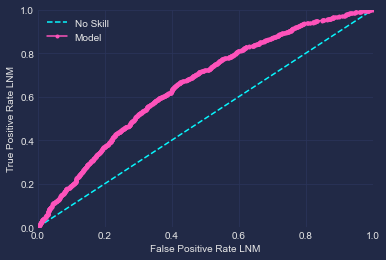

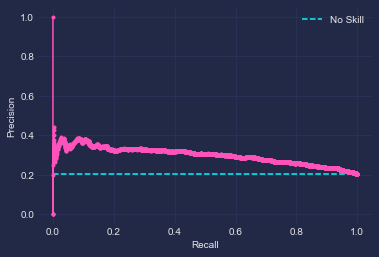

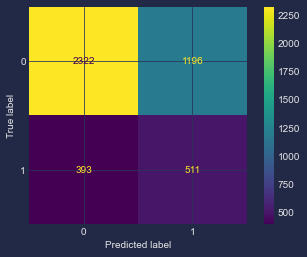

In [52]:
model_performance_plots(over_train_X, over_train_y, valid_X, valid_y, rf_optimized)

## Threshold analysis on optimized RF

In [53]:
x = np.arange(.01,1,.01)
probs = rf_optimized.predict_proba(valid_X)[:, 1]
for i in x:
    probabilities_pred = np.where(probs > i, 1, 0)
    p = precision_score(valid_y, probabilities_pred)
    if p > 0.35:
        print(i, p)

0.64 0.3790322580645161
0.65 0.37894736842105264
0.67 0.37349397590361444
0.68 0.36
0.7100000000000001 0.42857142857142855


f1 score: 0.017167381974248927
Precision Score: 0.2857142857142857
Accuracy Score: 0.7928539122568974



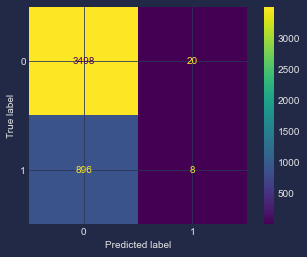

In [54]:
confm(valid_X, valid_y, rf_optimized, 0.69)